# Universidad Internacional del Ecuador  
## Procesamiento de Imágenes y Señales  
### Deber 2 — Semana 2 (FFT y Filtros)

**Grupo 6**  
- DARIO WLADIMIR HERRERA CHÁVEZ  
- JONATHAN FABRICIO GUALLI RAMIREZ  
- JORGE ARMANDO QUIZAMANCHURO FUEL  

---

## Notebook 02: Frecuencias Principales y Filtrado (Guitarra vs Batería)

En este notebook se realiza lo siguiente:

1. **Carga de la canción** (`cancion.wav`) y conversión a mono.
2. Cálculo de **STFT** para obtener el **espectro promedio** y analizar **frecuencias principales** presentes en la señal.
3. Aplicación de filtros para separación parcial por bandas:
   - **Filtro pasa-altos** para atenuar principalmente componentes de batería (kick/bajos).
   - **Filtro pasa-banda** para resaltar componentes típicas de guitarra.
4. Exportación de los audios filtrados y comparación espectral antes/después.

📌 **Nota**  
Ejecuta el notebook en orden secuencial para asegurar que las funciones y variables estén disponibles.

🔗 **Link Repositorio:** https://github.com/TU_USUARIO/UIDE-Procesamiento-Imagenes-Senales-Deber-2


## Imports

In [1]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Project root añadido:", project_root)

Project root añadido: /Users/georgenton/Documents/Proyectos/UIDE/UIDE-Procesamiento-Imagenes-Senales-Deber-2


## Imports + utilidades

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa

from src.dsp_filters import (
    normalize_audio,
    design_iir_highpass,
    design_iir_bandpass,
    apply_iir
)

def sanitize_audio(sig):
    """
    Elimina NaN/Inf y normaliza de forma segura.
    (Arregla el error: 'Audio buffer is not finite everywhere')
    """
    sig = np.asarray(sig, dtype=np.float32)
    sig = np.nan_to_num(sig, nan=0.0, posinf=0.0, neginf=0.0)
    peak = np.max(np.abs(sig))
    if peak < 1e-9:
        return sig
    return sig / peak


## Cargar canción + análisis de frecuencias

fs: 44100 duración(s): 13.783537414965986
Top frecuencias (Hz): [129.2   64.6  118.43 193.8  139.97  75.37 258.4  183.03 107.67 204.57
  96.9  247.63]


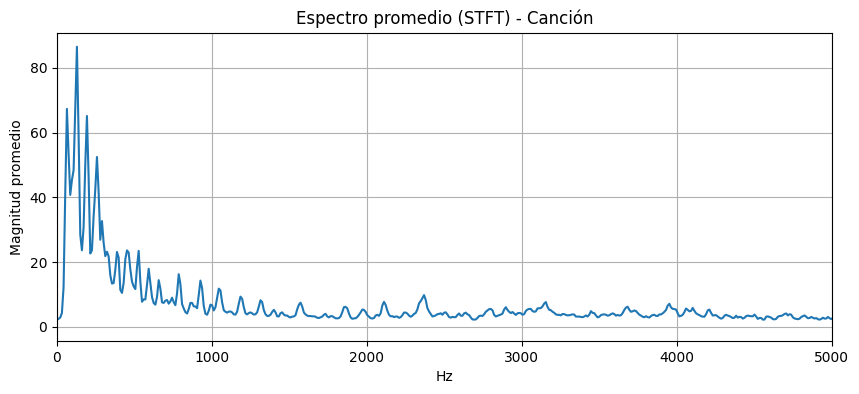

In [3]:
# === CARGA DE CANCIÓN ===
song_path = "../data/raw/cancion.wav"  # <-- asegúrate de que exista
x, fs = sf.read(song_path)

# Mono si es estéreo
if x.ndim > 1:
    x = x[:, 0]

x = sanitize_audio(x)

print("fs:", fs, "duración(s):", len(x)/fs)

# === STFT para "frecuencias principales" ===
n_fft = 4096
hop = 512

X = librosa.stft(x, n_fft=n_fft, hop_length=hop, window="hann")
mag = np.abs(X)
freqs = librosa.fft_frequencies(sr=fs, n_fft=n_fft)

avg_mag = mag.mean(axis=1)

top_idx = np.argsort(avg_mag)[-12:][::-1]
top_freqs = freqs[top_idx]

print("Top frecuencias (Hz):", np.round(top_freqs, 2))

plt.figure(figsize=(10,4))
plt.plot(freqs, avg_mag)
plt.xlim(0, 5000)
plt.title("Espectro promedio (STFT) - Canción")
plt.xlabel("Hz")
plt.ylabel("Magnitud promedio")
plt.grid(True)
plt.show()


## Filtros (HP batería, BP guitarra) + comparación espectral

In [4]:
# ===== FILTRO PASA-ALTOS (REDUCIR BATERÍA) =====

from scipy.signal import butter, sosfiltfilt
fc_hp = 180.0
order = 4

nyq = 0.5 * fs
sos_hp = butter(order, fc_hp/nyq, btype="high", output="sos")

y_hp = sosfiltfilt(sos_hp, x)
y_hp = sanitize_audio(y_hp)

sf.write(
    "../data/processed/cancion_highpass_sin_bateria.wav",
    (y_hp * 32767).astype(np.int16),
    fs,
    subtype="PCM_16"
)

# ===== FILTRO PASA-BANDA (GUITARRA) =====
low, high = 100.0, 6000.0

sos_bp = butter(order, [low/nyq, high/nyq], btype="band", output="sos")

y_bp = sosfiltfilt(sos_bp, x)
y_bp = sanitize_audio(y_bp)

sf.write(
    "../data/processed/cancion_bandpass_guitarra.wav",
    (y_bp * 32767).astype(np.int16),
    fs,
    subtype="PCM_16"
)

# ===== COMPARACIÓN ESPECTRAL =====
def avg_spectrum(sig, fs, n_fft=4096, hop=512):
    sig = sanitize_audio(sig)
    X = librosa.stft(sig, n_fft=n_fft, hop_length=hop, window="hann")
    mag = np.abs(X).mean(axis=1)
    freqs = librosa.fft_frequencies(sr=fs, n_fft=n_fft)
    return freqs, mag

f, m0 = avg_spectrum(x, fs)
_, m1 = avg_spectrum(y_hp, fs)
_, m2 = avg_spectrum(y_bp, fs)

plt.figure(figsize=(10,4))
plt.plot(f, m0, label="Original", alpha=0.5)
plt.plot(f, m1, label="High-pass (batería atenuada)", alpha=0.9)
plt.plot(f, m2, label="Band-pass (guitarra)", alpha=0.9)
plt.xlim(0, 5000)
plt.title("Comparación espectral promedio")
plt.xlabel("Hz")
plt.ylabel("Magnitud promedio")
plt.grid(True)
plt.legend()
plt.show()


NameError: name 'butter' is not defined